In [1]:
# Method to access the transaction data of the routing node: RTL (LND or Eclair) or gRPC
#data_access_method = "gRPC"
data_access_method = "RTL"

# Set the following to adjust the appearance of the static matplotlib graph, if needed
figuresize = 10 # Larger will increase the size of the graph
smallest_node = 100 # The smallest node size in pixels
color_factor = 2 # Higher will skew colors to green (higher fees)
node_size_factor = 0.5 # Larger will skew sizes to larger nodes (higher total transactions)
edge_width_factor = 0.1 # Larger will adjust to thicker edges
min_alpha_threshold = 0.2 # Larger will show more internode transactions

In [2]:
if (data_access_method == "gRPC"):

    # Replace with your routing node's certificate, macaroon file path, server port and protobuf file location
    cert_file = r'D:\lnd\node1\tls.cert'
    macaroon_file = r'D:\lnd\node1\data\chain\bitcoin\regtest\admin.macaroon'
    rpcserver = 'localhost:10009'
    protobuf_file_location = r'D:\lnd\proto\lnd\lnrpc' # Location of generated Protobuf files
    
    import sys
    # Ensure that this is the same version of Python that was used to generate the protobuf files
    print ("Ensure that this is the same version of Python that was used to generate the protobuf files")
    print(sys.executable)
    print(sys.version)
    
    sys.path.append(protobuf_file_location)
    
    import grpc
    import os
    from google.protobuf.json_format import MessageToDict
    from lightning_pb2 import ForwardingHistoryRequest
    from lightning_pb2 import ChannelGraphRequest
    from lightning_pb2 import GetInfoRequest
    from lightning_pb2_grpc import LightningStub
    
elif (data_access_method == "RTL"):
    
    # Replace with the name of the Ride The Lightning Forwarding History CSV file
    # Note: the provided 5 days of sample data has been anonymized for privacy. Using actual RTL node data will show the node ids
    RTL_file = "Forwarding-history-Sample.csv"
else: 
    
    print("Unsupported data access method.", data_access_method, " Must be gRPC or RTL")
    sys.exit(1)

In [3]:
def date_to_unix_timestamp(year, month, day, hour=0, minute=0, second=0):
    """Convert a date to a Unix timestamp."""
    dt = datetime.datetime(year, month, day, hour, minute, second)
    return int(dt.timestamp())

In [4]:
# Set the required date/time range for gRPC as needed
if (data_access_method == "gRPC"):
    
    import datetime

    # Examples:
    start = date_to_unix_timestamp(2023, 1, 1)  # January 1, 2023, at 00:00:00
    end = date_to_unix_timestamp(2023, 12, 31, 23, 59, 59)  # January 31, 2023, at 23:59:59

In [5]:
import pandas as pd
import networkx as nx
import ipycytoscape
import time
import matplotlib.pyplot as plt
from matplotlib import font_manager
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import datetime

In [6]:
# Function to create a gRPC channel with the LND routing node
def create_grpc_channel(cert_file, macaroon_file, rpcserver):
    try:
        with open(cert_file, 'rb') as f:
            cert = f.read()
        with open(macaroon_file, 'rb') as f:
            macaroon = f.read().hex()
    
        credentials = grpc.ssl_channel_credentials(cert)
        channel = grpc.secure_channel(rpcserver, credentials)
        return channel, macaroon
    except (FileNotFoundError, IOError) as e:
        print(f"Error reading cert or macaroon file: {e}")
        sys.exit(1)
    except Exception as e:
        print(f"Unexpected error in creating gRPC channel: {e}")
        sys.exit(1)

In [7]:
def get_node_info(stub, macaroon):
    try:
        request = GetInfoRequest()
        metadata = [('macaroon', macaroon)]
        response = stub.GetInfo(request, metadata=metadata)
        return response
    except grpc.RpcError as e:
        print(f"gRPC error: {e.details()}")
        sys.exit(1)
    except Exception as e:
        print(f"Unexpected error in fetching node info: {e}")
        sys.exit(1)

In [8]:
# Function to get forwarding history
def get_forwarding_history(stub, start_time, end_time, macaroon):
    try:
        # Create a request with the specified time range (in Unix timestamp)
        request = ForwardingHistoryRequest(start_time=start_time, end_time=end_time, num_max_events=10000)
        #request = ForwardingHistoryRequest()
    
        # Include the macaroon in the metadata
        metadata = [('macaroon', macaroon)]

        # Make the gRPC call
        response = stub.ForwardingHistory(request, metadata=metadata)
    
        # Convert response to dictionary
        events = [MessageToDict(event) for event in response.forwarding_events]
    
        # Return as pandas DataFrame
        return pd.DataFrame(events)
    except grpc.RpcError as e:
        print(f"gRPC error: {e.details()}")
        sys.exit(1)
    except Exception as e:
        print(f"Unexpected error getting forwarding history info: {e}")
        sys.exit(1)
        


In [9]:
def get_network_graph(stub, macaroon):
    
    try:
        # Include the macaroon in the metadata
        metadata = [('macaroon', macaroon)]
    
        request = ChannelGraphRequest(include_unannounced=True)
        response = stub.DescribeGraph(request, metadata=metadata)
        return response
    except grpc.RpcError as e:
        print(f"gRPC error: {e.details()}")
        sys.exit(1)
    except Exception as e:
        print(f"Unexpected error while getting the network graph: {e}")
        sys.exit(1)
        

In [10]:
def create_node_id_to_alias_map(graph):
    node_id_to_alias = {}
    for node in graph.nodes:
        node_id_to_alias[node.pub_key] = node.alias
    return node_id_to_alias

In [11]:
def create_channel_id_to_node_ids_map(graph):
    channel_id_to_node_ids = {}
    for edge in graph.edges:
        channel_id_to_node_ids[str(edge.channel_id)] = (edge.node1_pub, edge.node2_pub)
    return channel_id_to_node_ids

In [12]:
def get_alias_for_channel(channel_id, channel_id_to_node_ids, node_id_to_alias, exclude_node_pub_key):
    node_ids = channel_id_to_node_ids.get(str(channel_id), None)
    if node_ids:
        # Filter out the excluded node alias and return the other alias
        aliases = [node_id_to_alias.get(node_id) for node_id in node_ids if node_id != exclude_node_pub_key]
        if aliases:
            return aliases[0]
    return None


In [13]:
def load_data(filepath):
    try:
        df = pd.read_csv(filepath, encoding='utf-8')

        # Define the column name mappings for LND and Eclair
        lnd_columns = {
            'amt_in_msat': 'amt_in_msat',
            'amt_out_msat': 'amt_out_msat',
            'fee_msat': 'fee_msat',
            'alias_in': 'alias_in',
            'alias_out': 'alias_out'
        }
        eclair_columns = {
            'amountIn': 'amt_in_msat',
            'amountOut': 'amt_out_msat',
            'fromChannelAlias': 'alias_in',
            'toChannelAlias': 'alias_out'
        }

        # Detect the format (LND or Eclair) based on the column names
        #print (df.columns)
        if set(lnd_columns.keys()).issubset(df.columns):
            column_map = lnd_columns
        elif set(eclair_columns.keys()).issubset(df.columns):
            column_map = eclair_columns
            # Calculate fee_msat as the difference between amountIn and amountOut
            df['fee_msat'] = df['amountIn'] - df['amountOut']
        else:
            raise ValueError("CSV format not recognized. Please ensure it's either LND or Eclair format.")

        # Rename the columns
        df.rename(columns=column_map, inplace=True)

        return df

    except FileNotFoundError:
        print(f"Error: The file {filepath} was not found.")
    except pd.errors.EmptyDataError:
        print(f"Error: The file {filepath} is empty.")
    except pd.errors.ParserError:
        print(f"Error: The file {filepath} does not appear to be a valid CSV or is improperly formatted.")
    except ValueError as e:
        print(f"Error: {e}")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

    return None

In [14]:
def add_nodes_and_edges(G, df):
    """Add nodes and edges to the graph G based on the dataframe df."""
    for index, row in df.iterrows():
        
        # Convert node names to strings to handle numerical aliases
        u = str(row['alias_in'])
        v = str(row['alias_out'])
        
        # Convert 'amt_out_msat' and 'fee_msat' to integers
        weight = int(row['amt_out_msat'])
        fee = int(row['fee_msat'])
                
        # Check if there's already an edge (i.e., a previous transaction between these channels)
        if G.has_edge(u, v):
            edge_data = G[u][v]
            edge_data['weight'] += weight
            edge_data['fees'].append(fee)
        else:
            G.add_edge(u, v, weight=weight, fees=[fee])
    
    # Average out the fees and compute total transactions
    total_transactions = sum(nx.get_edge_attributes(G, 'weight').values())
    for u, v, d in G.edges(data=True):
        d['avg_fee'] = sum(d['fees']) / len(d['fees'])
        d['normalized_fee'] = d['avg_fee'] / total_transactions * 10000

    return total_transactions


In [15]:
def assign_classes_to_nodes(cyto_graph, df):
    # Ensure numeric columns are of the correct type
    df['fee_msat'] = pd.to_numeric(df['fee_msat'], errors='coerce').fillna(0)
    df['amt_out_msat'] = pd.to_numeric(df['amt_out_msat'], errors='coerce').fillna(0)

    # Calculate total fees and total transactions for each node
    total_fees = df.groupby('alias_out')['fee_msat'].sum()
    total_transactions = df.groupby('alias_out')['amt_out_msat'].sum()

    # Normalize the values
    max_fee = total_fees.max()
    max_transaction = total_transactions.max()
    normalized_fees = total_fees / max_fee * 10000
    normalized_transactions = total_transactions / max_transaction * 10000

    # Adjust thresholds based on the distribution of your data
    fee_thresholds = [100,5000]  # example thresholds for low, medium, high fee
    transaction_thresholds = [500, 1000, 3000]  # example thresholds for tiny, small, medium, large transactions

    # Iterate over nodes to assign classes
    for node in cyto_graph.graph.nodes:
        node_alias = node.data['id']
        classes = []

        # Assign fee classes based on normalized fees
        fee = normalized_fees.get(node_alias, 0)
        #print (node_alias, fee)
        if fee == 0:
            classes.append('no_fee')
        elif fee <= fee_thresholds[0]:
            classes.append('low_fee')
        elif fee <= fee_thresholds[1]:
            classes.append('medium_fee')
        else:
            classes.append('high_fee')

        # Assign transaction size classes based on normalized transactions
        trans = normalized_transactions.get(node_alias, 0)
        #print (node_alias, trans)
        if trans <= transaction_thresholds[0]:
            classes.append('tiny_transaction')
        elif trans <= transaction_thresholds[1]:
            classes.append('small_transaction')
        elif trans <= transaction_thresholds[2]:
            classes.append('medium_transaction')
        else:
            classes.append('large_transaction')

        node.classes = ' '.join(classes)

In [16]:
def assign_classes_to_edges(cyto_graph, G, total_transactions):
    # Normalize transactions for edges
    for u, v, d in G.edges(data=True):
        d['weight'] = int(d.get('weight', 0))  # Convert to integer
        d['normalized_transaction'] = d['weight'] / total_transactions * 10000

    # Iterate over edges to assign classes
    for edge in cyto_graph.graph.edges:
        u, v = edge.data['source'], edge.data['target']
        d = G[u][v]
        
        normalized_transaction = d['normalized_transaction']

        if normalized_transaction < 1:
            edge.classes = 'tiny_volume'
        elif normalized_transaction < 10:
            edge.classes = 'small_volume'
        elif normalized_transaction < 100:
            edge.classes = 'medium_volume'
        else:
            edge.classes = 'large_volume'

In [17]:
# Set styles based on classes
def set_styles (cyto_graph):
    
    cyto_graph.set_style([
        {
            'selector': 'node.no_fee',
            'style': {
                'content': 'data(id)',
                'background-color': 'red'
            }
        },
        {
            'selector': 'node.low_fee',
            'style': {
                'content': 'data(id)',
                'background-color': 'orange'
            }
        },
        {
            'selector': 'node.medium_fee',
            'style': {
                'content': 'data(id)',
                'background-color': 'yellow'
            }
        },
        {
            'selector': 'node.high_fee',
            'style': {
                'content': 'data(id)',
                'background-color': 'green'
            }
        },
            {
            'selector': 'node.tiny_transaction',
            'style': {
                'width': '10px',
                'height': '10px'
            }
        },
        {
            'selector': 'node.small_transaction',
            'style': {
                'width': '20px',
                'height': '20px'
            }
        },
        {
            'selector': 'node.medium_transaction',
            'style': {
                'width': '30px',
                'height': '30px'
            }
        },
        {
            'selector': 'node.large_transaction',
            'style': {
                'width': '50px',
                'height': '50px'
            }
        },
        {
            'selector': 'edge.tiny_volume',
            'style': {
                'width': '0px',
                'line-color': 'grey'
            }
        },
        {
            'selector': 'edge.small_volume',
            'style': {
                'width': '1px',
                'line-color': 'grey'
            }
        },
        {
            'selector': 'edge.medium_volume',
            'style': {
                'width': '2px',
                'line-color': 'grey'
            }
        },
        {
            'selector': 'edge.large_volume',
            'style': {
                'width': '3px',
                'line-color': 'black'
            }
        }
    ])


In [18]:
def update_edge_attributes(G, df):
    # Calculate total transactions for each edge
    df['normalized_transaction'] = df['amt_out_msat'] / df['amt_out_msat'].max() * 10000
    edge_transactions = df.groupby(['alias_in', 'alias_out'])['normalized_transaction'].sum().to_dict()
    
    # Iterate over edges to assign attributes
    for u, v in G.edges():
        G[u][v]['normalized_transaction'] = edge_transactions.get((u, v), 0)


In [19]:
def update_node_attributes(G, df):
    # Calculate total fees and total transactions for each node
    total_fees = df.groupby('alias_out')['fee_msat'].sum()
    total_transactions = df.groupby('alias_out')['amt_out_msat'].sum()
    
    # Normalize the values
    max_fee = total_fees.max()
    max_transaction = total_transactions.max()
    normalized_fees = (total_fees / max_fee * 10000).to_dict()
    normalized_transactions = (total_transactions / max_transaction * 10000).to_dict()
    
    # Iterate over nodes to assign attributes
    for node in G.nodes():
        G.nodes[node]['normalized_fee'] = normalized_fees.get(node, 0)
        G.nodes[node]['normalized_transaction'] = normalized_transactions.get(node, 0)

In [20]:
# Convert the integer RGB values to a float format (0 to 1)
def convert_rgb_to_float(rgb):
    return tuple(value / 255 for value in rgb)

In [21]:
def save_visualization():

    # Generate a timestamp for the filename
    timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    filename = f"LNVisualization.{timestamp}.png"
    
    # Save the figure
    plt.savefig(filename, format='png', dpi=300)
    print(f"Graph saved as {filename}")

    # Show the plot
    plt.show()

In [22]:
# Load the data, either from the transaction CSV file or from the network via gRPC

if (data_access_method == "RTL"):
    df = load_data (RTL_file)
      
else:

    channel, macaroon = create_grpc_channel(cert_file, macaroon_file, rpcserver)
    stub = LightningStub(channel)

    # Extract the public key of the routing node
    node_info = get_node_info(stub, macaroon)
    routing_node_pub_key = node_info.identity_pubkey

    # Fetch forwarding history
    df = get_forwarding_history(stub, start, end, macaroon)

    # Fetch the graph and create the maps
    graph = get_network_graph(stub, macaroon)

    node_id_to_alias = create_node_id_to_alias_map(graph)
    channel_id_to_node_ids = create_channel_id_to_node_ids_map(graph)

    # Exclude the routing node itself from the network graph
    exclude_node_pub_key = routing_node_pub_key

    # When applying the aliases to the DataFrame
    df['alias_in'] = df['chanIdIn'].apply(lambda x: get_alias_for_channel(x, channel_id_to_node_ids, node_id_to_alias, exclude_node_pub_key))
    df['alias_out'] = df['chanIdOut'].apply(lambda x: get_alias_for_channel(x, channel_id_to_node_ids, node_id_to_alias, exclude_node_pub_key))

    # ALign the column names returned from gRPC with the CSV column names
    df = df.rename(columns={
    'feeMsat': 'fee_msat',
    'amtInMsat': 'amt_in_msat',
    'amtOutMsat': 'amt_out_msat',
    'timestampNs': 'timestamp_ns'
    })

# Check if the data was loaded successfully
if df is None:
    # If df is None, print an error message and exit
    print("Transaction data could not be loaded. Please check the file path and format or API connection.")
    sys.exit(1)

In [23]:
# Use ipycytoscape to draw an interactive dynamic graph

# Create a new Cytograph
G = nx.Graph()

total_transactions = add_nodes_and_edges(G, df)

# Create the Cytoscape widget
cyto_graph = ipycytoscape.CytoscapeWidget()

# Set a custom ID
custom_widget_id = "my_custom_cytoscape_widget"
cyto_graph.add_class(custom_widget_id)  # Add the ID as a class

cyto_graph.graph.add_graph_from_networkx(G)

cyto_graph.set_layout(name='circle')

assign_classes_to_nodes (cyto_graph, df)
assign_classes_to_edges (cyto_graph, G, total_transactions)

set_styles (cyto_graph)

# Notes: 
# Ensure that ipytoscape is enabled in Jupyter Lab or Jupyter Notebook, in a Conda shell run the following
# jupyter nbextension enable --py --sys-prefix ipycytoscape
# Start Jupyter with "jupyter notebook (or jupyter lab) --NotebookApp.iopub_data_rate_limit=1.0e10 --NotebookApp.iopub_msg_rate_limit=1.0e10", in Powershell if datarate is exceeded
# This can happen with large numbers of transactions
# Zoom on the widget with the mousewheel, drag the whole graph or just nodes with left click
# Right click and select 'Create new view for output' for more real estate.
# Windows Key + Shift + S (or other snipping tool) to copy a screenshot to the paste buffer

cyto_graph

CytoscapeWidget(cytoscape_layout={'name': 'circle'}, cytoscape_style=[{'selector': 'node.no_fee', 'style': {'c…

Graph saved as LNVisualization.20231213-155232.png


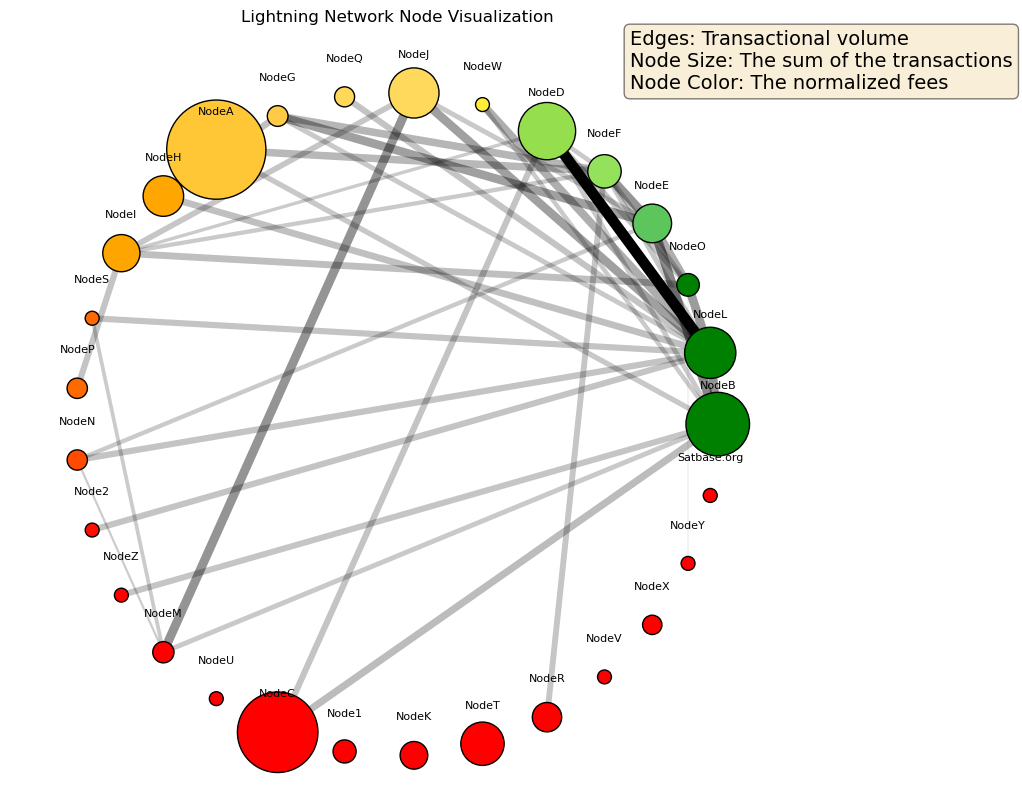

In [24]:
# Use matplotlib to draw a static graph that can be sorted and saved

# 'G' is your NetworkX graph object that has been filled with nodes and edges
# 'df' is your DataFrame containing the 'normalized_transaction' and 'normalized_fee'

# Update node and edge attributes in G
update_node_attributes(G, df)
update_edge_attributes(G, df)

# Get the fees from the node attributes and normalize them
fee_dict = nx.get_node_attributes(G, 'normalized_fee')
max_fee = max(fee_dict.values())
min_fee = min(fee_dict.values())

# Normalize the fees to a range of 0 to 1 for color mapping
normalized_fee_colors = {node: (fee - min_fee) / (max_fee - min_fee) for node, fee in fee_dict.items()}

# Sort nodes by fees
sorted_nodes = sorted(G.nodes(), key=lambda node: fee_dict[node], reverse=True)

# Compute positions in a circle while sorting by fee
angle_step = 2 * np.pi / len(G.nodes())
pos = {node: (np.cos(angle), np.sin(angle)) for angle, node in zip(angle_step * np.arange(len(sorted_nodes)), sorted_nodes)}

# Define edge widths based on a logarithmic scale of normalized transactions
edge_widths = [np.log1p(G[u][v]['normalized_transaction'] * edge_width_factor) for u, v in G.edges()]

# Define node sizes based on normalized transactions
node_sizes = [smallest_node + node_size_factor * G.nodes[node]['normalized_transaction'] for node in sorted_nodes]

# Define your colors with their RGB values
green = convert_rgb_to_float((0, 128, 0))     # Green color in RGB
light_green = convert_rgb_to_float((144, 238, 144))    # Light-Green color in RGB
yellow_green = convert_rgb_to_float((154, 205, 0))     # Yellow-Green color in RGB
yellow = convert_rgb_to_float((255, 255, 0))  # Yellow color in RGB
light_orange_yellow = convert_rgb_to_float((255, 224, 102))
orange_yellow = convert_rgb_to_float((255, 200, 66)) # Orange-Yellow color in RGB
amber = convert_rgb_to_float((255, 191, 0)) # Amber color in RGB
dark_orange_yellow = convert_rgb_to_float((255, 165, 0))
orange = convert_rgb_to_float((255, 165, 0))  # Orange color in RGB

# Create the custom colormap
cmap = LinearSegmentedColormap.from_list('my_custom_cmap', [green, light_green, yellow_green, yellow, light_orange_yellow, 
                                                            orange_yellow, amber, dark_orange_yellow, orange, "red"][::-1], N=100)

# Create a list of tuples (node, color)
node_colors = [(node, cmap(normalized_fee_colors[node] * color_factor)) for node in sorted_nodes]

# Sort this list by the order of nodes in G.nodes()
# This step ensures that the node order in G.nodes() and node_colors match
node_colors_sorted_by_graph = sorted(node_colors, key=lambda x: list(G.nodes()).index(x[0]))

# Now, extract the sorted color list
sorted_color_list = [color for _, color in node_colors_sorted_by_graph]

# Start a new figure for plotting
fig, ax = plt.subplots(figsize=(figuresize, figuresize))

# Add a text box with your key
textstr = '\n'.join((
    "Edges: Transactional volume",
    "Node Size: The sum of the transactions",
    "Node Color: The normalized fees"
))

# These are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

# Place a text box in upper left in axes coords
ax.text (0.8, 1, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=sorted_color_list, edgecolors='black', linewidths=1)

# Assuming normalized_transaction values are between 0 and 1
max_alpha_value = max([G[u][v]['normalized_transaction'] for u, v in G.edges()])
edge_alphas = [(G[u][v]['normalized_transaction'] / max_alpha_value) * (1 - min_alpha_threshold) + min_alpha_threshold for u, v in G.edges()]

# Draw the edges with dynamic alpha
for (u, v), width, alpha in zip(G.edges(), edge_widths, edge_alphas):
    nx.draw_networkx_edges(G, pos, edgelist=[(u, v)], width=width, alpha=alpha, edge_color='black')

# Offset for the labels: adjust the value to set the desired distance
label_offset = 0.1

# Calculate new positions for labels
label_pos = {node: (position[0], position[1] + label_offset) for node, position in pos.items()}

# Draw the node labels with adjusted positions
labels = {node: f"{node}" for node in G.nodes()}
nx.draw_networkx_labels(G, label_pos, labels=labels, font_size=8, verticalalignment='bottom', horizontalalignment='center')
plt.rcParams['font.family'] = 'Segoe UI Symbol'

# Remove the axes
plt.axis('off')

# Set the title of the plot
plt.title('Lightning Network Node Visualization')

# Save the graph
save_visualization()
